In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import h5py

from sklearn import metrics

from tensorflow import keras

import sys

from glob import glob

from scipy import stats

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sys.path.append('../algorithms/')
sys.path.append('../')

In [5]:
import datatools
import config

In [5]:
import pltconfig
pltconfig.apply_style(plt)

## Load Data

In [24]:
SIM=f"{config.SIM}/{config.CARD}_bkgr_{config.BKGR}"
SIG_LOC=f"{SIM}/TEST/WithMuon*Rnd31680*.h5"
BKG_LOC=f"{SIM}/TEST/NoMuon*.h5"

files=glob(SIG_LOC) + glob(BKG_LOC)

print(f"files with muon: {len(glob(SIG_LOC))} and no Muon: {len(glob(BKG_LOC))}")

COLORS = mpl.colormaps['Dark2'].colors
print (COLORS)


files with muon: 4 and no Muon: 4
((0.10588235294117647, 0.6196078431372549, 0.4666666666666667), (0.8509803921568627, 0.37254901960784315, 0.00784313725490196), (0.4588235294117647, 0.4392156862745098, 0.7019607843137254), (0.9058823529411765, 0.1607843137254902, 0.5411764705882353), (0.4, 0.6509803921568628, 0.11764705882352941), (0.9019607843137255, 0.6705882352941176, 0.00784313725490196), (0.6509803921568628, 0.4627450980392157, 0.11372549019607843), (0.4, 0.4, 0.4))


In [8]:
data, dmat, Y, Y_mu, Y_hit, sig_keys = datatools.make_data_matrix(files, max_files=700, sort_by='z')

  0%|          | 0/20000 [00:00<?, ?it/s]

~~ Reading data... ~~
~~ Calculating occupancy information... ~~


100%|██████████| 20000/20000 [00:00<00:00, 58709.26it/s]

!!
I read 20000 events, of which 10000 have muon and 10000 do not
!!


## Occupancy plots

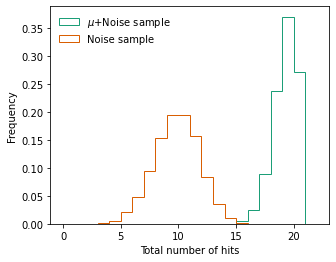

In [26]:
ncols, nrows = (1,1)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5*ncols,4*nrows))

axs.hist(data['ev_n_signals'][Y_mu==1], density=True, histtype='step', bins=22, range=(0,22), label=r'$\mu$+Noise sample', color=COLORS[0])
axs.hist(data['ev_n_signals'][Y_mu==0], density=True, histtype='step', bins=22, range=(0,22), label='Noise sample', color=COLORS[1])

axs.legend(loc='upper left', frameon=False)

axs.set_xlabel('Total number of hits')
axs.set_ylabel('Frequency')

plt.savefig('plots_noise/tot_hits.pdf', bbox_inches='tight')

plt.show()

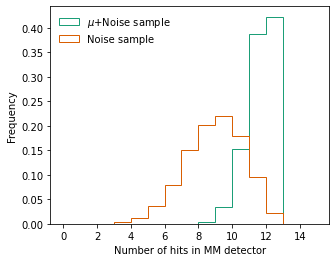

In [27]:
ncols, nrows = (1,1)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5*ncols,4*nrows))

axs.hist(data['n_sig_mm'][Y_mu==1], density=True, histtype='step', bins=15, range=(0,15), label=r'$\mu$+Noise sample', color=COLORS[0])
axs.hist(data['n_sig_mm'][Y_mu==0], density=True, histtype='step', bins=15, range=(0,15), label='Noise sample', color=COLORS[1])

axs.legend(loc='upper left', frameon=False)

axs.set_xlabel('Number of hits in MM detector')
axs.set_ylabel('Frequency')

plt.savefig('plots_noise/tot_hits_mm.pdf', bbox_inches='tight')

plt.show()

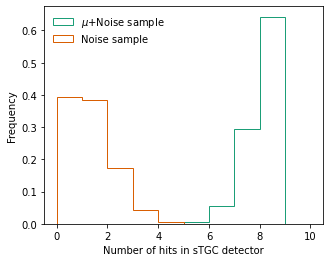

In [28]:
ncols, nrows = (1,1)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5*ncols,4*nrows))

axs.hist(data['n_sig_stgc'][Y_mu==1], density=True, histtype='step', bins=10, range=(0,10), label=r'$\mu$+Noise sample', color=COLORS[0])
axs.hist(data['n_sig_stgc'][Y_mu==0], density=True, histtype='step', bins=10, range=(0,10), label='Noise sample', color=COLORS[1])

axs.legend(loc='upper left', frameon=False)

axs.set_xlabel('Number of hits in sTGC detector')
axs.set_ylabel('Frequency')

plt.savefig('plots_noise/tot_hits_stgc.pdf', bbox_inches='tight')

plt.show()

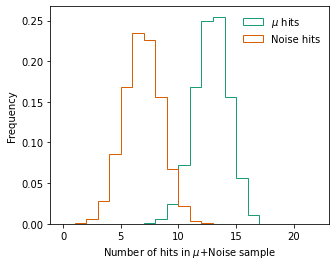

In [29]:
ncols, nrows = (1,1)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5*ncols,4*nrows))

axs.hist(data['ev_n_mu_signals'][Y_mu==1], density=1, histtype='step', bins=22, range=(0,22), label=f'$\mu$ hits', color=COLORS[0])
axs.hist(data['ev_n_signals'][Y_mu==1]-data['ev_n_mu_signals'][Y_mu==1], density=1, histtype='step', bins=22, range=(0,22), label=f'Noise hits', color=COLORS[1])

axs.legend(loc='upper right', frameon=False)

axs.set_xlabel(f'Number of hits in $\mu$+Noise sample')
axs.set_ylabel('Frequency')

plt.savefig('plots_noise/mu_hits.pdf', bbox_inches='tight')

plt.show()

## MM timing plots

In [15]:
X_det = datatools.detector_matrix_2(dmat, sig_keys, detcard=config.DET)

  4%|▍         | 835/20000 [00:00<00:02, 8340.96it/s]

~~ Preparing detector-based data matrix ~~
Using detector card: /afs/cern.ch/work/r/rrojas/public/ML/r-dev-branch/si-mu-lator/cards/atlas_nsw_pad_z0.yml
[0, 5.1, 21.9, 27.0, 92.0, 103.5, 125.2, 125.2, 136.6, 136.6, 223.0, 223.0, 234.5, 234.5, 256.2, 267.6, 334.0, 339.1, 355.9, 361.0]


100%|██████████| 20000/20000 [00:02<00:00, 9207.43it/s] 

Output data matrix shape: (20000, 20, 20)


In [16]:
bc_time = X_det[:,:,sig_keys.index('time')].flatten()

In [17]:
is_mm_mu_id = ((X_det[:,:,sig_keys.index('ptype')]==0)*((X_det[:,:,sig_keys.index('is_signal')]==1))*((X_det[:,:,sig_keys.index('is_muon')]==1))).flatten()

In [18]:
is_mm_bkg_id = ((X_det[:,:,sig_keys.index('ptype')]==0)*((X_det[:,:,sig_keys.index('is_signal')]==1))*((X_det[:,:,sig_keys.index('is_muon')]==0))).flatten()

In [19]:
bc_time.shape

(400000,)

In [20]:
is_mm_mu_id.shape

(400000,)

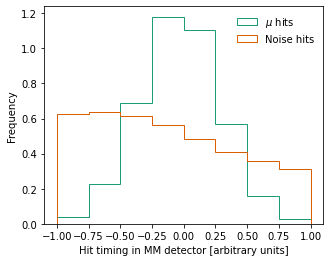

In [32]:
ncols, nrows = (1,1)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5*ncols,4*nrows))

axs.hist(bc_time[is_mm_mu_id], density=1, histtype='step',  bins=8, range=(-1,1), label=f'$\mu$ hits', color=COLORS[0])
axs.hist(bc_time[is_mm_bkg_id], density=1, histtype='step', bins=8, range=(-1,1), label=f'Noise hits', color=COLORS[1])

axs.legend(loc='upper right', frameon=False)

axs.set_xlabel(f'Hit timing in MM detector [arbitrary units]')
axs.set_ylabel('Frequency')

plt.savefig('plots_noise/bc_time.pdf', bbox_inches='tight')

plt.show()